In [1]:
# import the libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load data
First I load the relevant data files (museum data source: https://www.kaggle.com/annecool37/museum-data), which are separated into several sets and split between US and world data. For this analysis, I have not considered the additional data files containing tag clouds, review content, and review quotes due to the size (tag clouds) and need for NLP, considering the richness of the data even excluding these fields.

In [2]:
# load data

# museum info
df_museum_US = pd.read_csv('data/tripadvisor_museum_USonly.csv')
df_museum_world = pd.read_csv('data/tripadvisor_museum_world.csv')

# ratings
df_ratings_US = pd.read_json('data/traveler_type_USonly.json')
# df_ratings_US.columns = ['Excellent','Very good','Average','Poor','Terrible']
df_ratings_world = pd.read_json('data/traveler_type_world.json')
# df_ratings_world.columns = ['Excellent','Very good','Average','Poor','Terrible']

# traveler types
df_travelers_US = pd.read_json('data/traveler_type_USonly.json')
# df_travelers_US.columns = ['Families','Couples','Solo','Business','Friends']
df_travelers_world = pd.read_json('data/traveler_type_world.json')
# df_travelers_world.columns = ['Families','Couples','Solo','Business','Friends']

# museum categories - using json library to load as dict because pd.read_json throws error
# due to data of variable length (inconsistent # category types per museum)
with open('data/museum_categories_USonly.json') as json_data_US:
    json_category_US = json.load(json_data_US)
    
with open('data/museum_categories_world.json') as json_data_world:
    json_category_world = json.load(json_data_world)
    
# tag clouds - also loading as dict for same reason as museum categories
with open('data/tag_clouds_USonly.json') as json_data_US:
    json_tags_US = json.load(json_data_US)
    
with open('data/tag_clouds_world.json') as json_data_world:
    json_tags_world = json.load(json_data_world)

### Inspect and  clean data
I next inspect and clean the data per set (I will only combine US and world data per set at this stage - I will create a final merged set at the end). The json file column names are provided with data description on kaggle, and the US and world sets of each set should be the same format.

#### Museum info data:

In [3]:
# inspect museum info data
print('US museum info')
print(df_museum_US.columns)
print(df_museum_US.describe())
print(df_museum_US.info())
print(df_museum_US.head())
print('')
print('World museum info')
print(df_museum_world.columns)
print(df_museum_world.describe())
print(df_museum_world.info())
print(df_museum_world.head())


US museum info
Index(['Unnamed: 0', 'Address', 'Description', 'FeatureCount', 'Fee',
       'Langtitude', 'Latitude', 'LengthOfVisit', 'MuseumName', 'PhoneNum',
       'Rank', 'Rating', 'ReviewCount', 'TotalThingsToDo'],
      dtype='object')
       Unnamed: 0  FeatureCount  Langtitude  Latitude    Rank  Rating
count     1014.00       1014.00     1008.00   1008.00 1014.00 1014.00
mean       506.50          0.66      -92.45     37.17   15.19    4.45
std        292.86          1.66       17.18      5.80   28.24    0.30
min          0.00          0.00     -159.72     19.30    1.00    2.50
25%        253.25          0.00     -104.95     33.46    2.00    4.50
50%        506.50          0.00      -87.59     37.76    6.00    4.50
75%        759.75          0.00      -79.69     40.88   17.00    4.50
max       1013.00         12.00      -68.20     64.86  397.00    5.00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 14 columns):
Unnamed: 0         1

From these summaries, I observe the following:

1. The formats of both files were identical, so the data can be concatenated.
2. The first column appears to be the index, and can be dropped (I won't bother to reload the file with this as the index because it is just a basic numeric index)
3. Longitude column has been misspelled and should be updated.
4. There appear to be US entries in the world data set. This may indicate duplicate data.
5. The rank, feature count and rating have been correctly interpreted as numeric, but the review count and total things to do have not, so they must be fixed.
6. There appear to be missing values in the description, fee, latitude, longitude, length of visit columns, and phone number columns for both sets of data, which will need to be evaluated further.
7. I would like to use city, country and state information for my analysis, but there are no separate columns these fields, so I will try to parse these from the address to enable some diagnostic evaluation by location.

In [4]:
# concatenate US and world dataframes
df_museum = pd.concat([df_museum_US, df_museum_world]).reset_index()
df_museum.tail()

,index,Unnamed: 0,Address,Description,FeatureCount,Fee,Langtitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo
2021,1007,1007,"1 Bowling Grn, New York City, NY 10004-1415",The New York branch of the Smithsonian Institu...,1,No,-74.01,40.70,1-2 hours,National Museum of the American Indian,212-514-3700,91,4.00,474,"1,028"
2022,1008,1008,"Via Marconi, 1, 20122 Milan, Italy","The Museo del Novecento, located inside the Pa...",1,NaN,9.19,45.46,1-2 hours,Museo del Novecento,+39 0288444061,28,4.50,"1,197",622
2023,1009,1009,"10 Childrens Way, Pittsburgh, PA 15212-5250",Hi! We're having a great time at Children's Mu...,3,NaN,-80.01,40.45,More than 3 hours,Children's Museum of Pittsburgh,+1 412-322-5058,20,4.50,414,150
2024,1010,1010,"15 25a Buitenkant Street, Cape Town Central 80...",The apartheid nationalist government destroyed...,1,NaN,18.42,-33.93,NaN,District Six Museum,+27 21 466 7200,20,4.50,"1,083",218
2025,1011,1011,"64 King Edward Parade, Devonport 0624, New Zea...",NaN,0,NaN,174.81,-36.83,NaN,Torpedo Bay Navy Museum,+64 9-445 5186,2,4.50,143,11


In [5]:
# drop index and Unnamed: 0 columns and rename 'Langtitude' column to Longitude
df_museum.drop(['index','Unnamed: 0'], axis=1, inplace=True)
df_museum.rename(columns={'Langtitude':'Longitude'}, inplace=True)
df_museum.head()

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,"6,309",398
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,"36,627","1,028"
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,"15,611",319
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,"2,564",231
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,"15,532",614


In [6]:
# check for duplicate museum entries
print(df_museum.info())
print(df_museum[df_museum.duplicated()])

# drop duplicate entries
df_museum.drop_duplicates(keep='first', inplace=True)
print(df_museum.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 13 columns):
Address            2026 non-null object
Description        1542 non-null object
FeatureCount       2026 non-null int64
Fee                390 non-null object
Longitude          1980 non-null float64
Latitude           1980 non-null float64
LengthOfVisit      799 non-null object
MuseumName         2026 non-null object
PhoneNum           2017 non-null object
Rank               2026 non-null int64
Rating             2026 non-null float64
ReviewCount        2026 non-null object
TotalThingsToDo    2026 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 205.8+ KB
None
                                                Address  \
1014  555 Pennsylvania Ave NW, Washington DC, DC 200...   
1026        2001 N Colorado Blvd, Denver, CO 80205-5798   
1027         111 S Michigan Ave, Chicago, IL 60603-6488   
1033  465 Huntington Ave, Avenue of the Arts, Boston...   
1035      

Removing duplicate entries took the total count from 2026 to 1662.

In [7]:
# convert data type of ReviewCount and TotalThingsToDo
df_museum['ReviewCount'] = df_museum['ReviewCount'].str.replace(',','').astype(int)
df_museum['TotalThingsToDo'] = df_museum['TotalThingsToDo'].str.replace(',','').astype(int)
df_museum.info()
df_museum.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 0 to 2025
Data columns (total 13 columns):
Address            1662 non-null object
Description        1217 non-null object
FeatureCount       1662 non-null int64
Fee                260 non-null object
Longitude          1618 non-null float64
Latitude           1618 non-null float64
LengthOfVisit      607 non-null object
MuseumName         1662 non-null object
PhoneNum           1655 non-null object
Rank               1662 non-null int64
Rating             1662 non-null float64
ReviewCount        1662 non-null int32
TotalThingsToDo    1662 non-null int32
dtypes: float64(3), int32(2), int64(2), object(6)
memory usage: 168.8+ KB


,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,6309,398
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,36627,1028
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,15611,319
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,2564,231
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614


In [8]:
# number of missing values by columns
print(df_museum.isnull().sum())

Address               0
Description         445
FeatureCount          0
Fee                1402
Longitude            44
Latitude             44
LengthOfVisit      1055
MuseumName            0
PhoneNum              7
Rank                  0
Rating                0
ReviewCount           0
TotalThingsToDo       0
dtype: int64


Based on the number of missing values for Description, Fee and Length of Visit compared to the total number of entries (1662), and the fact that there is no reasonable way to interpolate this data, I will have to remove these columns from my analysis.

For the latitude and longitude, I could implement a geocoding service to populate missing values based on the address, but I am not going to do this for the sake of time,  and the fact that I won't use these columns in my analysis.

For the phone number, there is no way to interpolate the data even though there are very few missing entries, but I will also not be using this field.

In [9]:
# create city, country and state columns from address

# create string pattern to identify where an address is in the US - based on containing a 2 letter state abbreviation following a comma
state_pattern = ', [A-Z]{2}'

# create a Country column that assigns USA as the country when the Address contains a state abbreviation
# otherwise split the address based on a comma delimiter, and assign the country as the last element in this list, and strip whitespace
df_museum['Country'] = np.where((df_museum['Address'].str.contains(state_pattern)),'USA', df_museum['Address'].str.split(',').str[-1].str.strip())
df_museum.head()

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo,Country
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,6309,398,USA
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,36627,1028,USA
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,15611,319,USA
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,2564,231,USA
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614,USA


In [10]:
# check validity of Country column
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy'
 'Tokyo Prefecture' 'Mexico' 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia'
 'China' 'South Korea' 'Colombia' 'Czech Republic' 'Indonesia' 'Poland'
 'Hungary' 'Estonia' 'Australia' 'Ireland' 'Hiroshima Prefecture'
 'Malaysia' 'Osaka Prefecture' 'United Arab Emirates' 'Portugal' 'Israel'
 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India' 'Qatar'
 'New Zealand' 'The Netherlands (Formerly Netherlands Maritime Museum)'
 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium' 'South Africa'
 'Egypt' 'Cambodia' 'Shiga Prefecture' 'Brazil' 'Switzerland'
 'Aichi Prefecture' 'Thailand' 'Fukui Prefecture' 'Ishikawa Prefecture'
 'Finland' 'The Netherlands (Formerly Museum Het Prinsenhof)' 'Bulgaria'
 'Lithuania' 'Costa Rica (Formerly Gold Museum (Museo del Oro))' 'Serbia'
 'Northern Ireland' 'Slovakia' 'Latvia' 'Morocco' 'Shimane Prefecture'
 'Nagasaki Prefecture' 'Ne

In [11]:
# correct countries containing brackets
df_museum['Country'] = df_museum['Country'].str.split(" \(").str[0]
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy'
 'Tokyo Prefecture' 'Mexico' 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia'
 'China' 'South Korea' 'Colombia' 'Czech Republic' 'Indonesia' 'Poland'
 'Hungary' 'Estonia' 'Australia' 'Ireland' 'Hiroshima Prefecture'
 'Malaysia' 'Osaka Prefecture' 'United Arab Emirates' 'Portugal' 'Israel'
 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India' 'Qatar'
 'New Zealand' 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium'
 'South Africa' 'Egypt' 'Cambodia' 'Shiga Prefecture' 'Brazil'
 'Switzerland' 'Aichi Prefecture' 'Thailand' 'Fukui Prefecture'
 'Ishikawa Prefecture' 'Finland' 'Bulgaria' 'Lithuania' 'Costa Rica'
 'Serbia' 'Northern Ireland' 'Slovakia' 'Latvia' 'Morocco'
 'Shimane Prefecture' 'Nagasaki Prefecture' 'New Providence Island'
 'Kanagawa Prefecture' 'Taiwan' 'Bahrain' 'Saudi Arabia'
 'Saitama Prefecture' 'Ukraine' 'Curacao' 'Malta' 'Cuba' 'Hokkaido'
 'E

In [12]:
# convert entries containing 'Prefecture', and the entry Hokkaido to Japan
df_museum['Country'][(df_museum['Country'].str.contains('Prefecture')) | (df_museum['Country'] == 'Hokkaido')] = 'Japan'
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy' 'Japan' 'Mexico'
 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia' 'China' 'South Korea'
 'Colombia' 'Czech Republic' 'Indonesia' 'Poland' 'Hungary' 'Estonia'
 'Australia' 'Ireland' 'Malaysia' 'United Arab Emirates' 'Portugal'
 'Israel' 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India'
 'Qatar' 'New Zealand' 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium'
 'South Africa' 'Egypt' 'Cambodia' 'Brazil' 'Switzerland' 'Thailand'
 'Finland' 'Bulgaria' 'Lithuania' 'Costa Rica' 'Serbia' 'Northern Ireland'
 'Slovakia' 'Latvia' 'Morocco' 'New Providence Island' 'Taiwan' 'Bahrain'
 'Saudi Arabia' 'Ukraine' 'Curacao' 'Malta' 'Cuba' 'Ecuador' 'Uruguay'
 'Georgia' 'Kenya' 'Panama' 'Jamaica' 'Terra Cotta Warriors and Horses)'
 'Oman']


C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


I'm not sure why I'm getting this warning, because the command appears to have executed correctly. Any feedback would be appreciated.

In [13]:
# find address of incorrect entry "Terra Cotta Warriors and Horses)"
df_museum['Address'][df_museum['Country']=='Terra Cotta Warriors and Horses)']

1977    Qinling North Road, Lintong District, Xi'an 71...
Name: Address, dtype: object

In [14]:
# correct final country
df_museum['Country'][df_museum['Country']=='Terra Cotta Warriors and Horses)'] = 'China'
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy' 'Japan' 'Mexico'
 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia' 'China' 'South Korea'
 'Colombia' 'Czech Republic' 'Indonesia' 'Poland' 'Hungary' 'Estonia'
 'Australia' 'Ireland' 'Malaysia' 'United Arab Emirates' 'Portugal'
 'Israel' 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India'
 'Qatar' 'New Zealand' 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium'
 'South Africa' 'Egypt' 'Cambodia' 'Brazil' 'Switzerland' 'Thailand'
 'Finland' 'Bulgaria' 'Lithuania' 'Costa Rica' 'Serbia' 'Northern Ireland'
 'Slovakia' 'Latvia' 'Morocco' 'New Providence Island' 'Taiwan' 'Bahrain'
 'Saudi Arabia' 'Ukraine' 'Curacao' 'Malta' 'Cuba' 'Ecuador' 'Uruguay'
 'Georgia' 'Kenya' 'Panama' 'Jamaica' 'Oman']


C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
# for all entries in the USA, parse the city and state from the address
# possible for US based on regularity in address, but variability in world addresses make rule generation too complicated for this exercise

df_museum.loc[df_museum['Country'] == 'USA','City'] = df_museum['Address'].str.split(',').str[-2].str.strip()
df_museum.loc[df_museum['Country'] == 'USA','State'] = df_museum['Address'].str.split(',').str[-1].str.strip().str[:2]

print(df_museum['City'].unique())
print(df_museum['State'].unique())
df_museum.head()

['Washington DC' 'New York City' 'New Orleans' 'Denver' 'Chicago' 'Boston'
 'Pensacola' 'Dubuque' 'Hershey' 'Philadelphia' 'Sarasota' 'San Diego'
 'Los Angeles' 'Houston' 'Las Vegas' 'Nashville' 'Seattle' 'Dallas'
 'Tucson' 'San Francisco' 'Chamberlain' 'Phoenix' 'St. Petersburg'
 'Memphis' 'Pigeon Forge' 'Louisville' 'Kansas City' 'Oahu' 'Saint Louis'
 'Cleveland' 'Indianapolis' 'Dearborn' 'Tampa' 'San Jose' 'Oklahoma City'
 'Branson' 'Hickory Corners' 'Saint Augustine' 'Fort Lauderdale' 'Salem'
 'Pittsburgh' 'Raleigh' 'Dayton' 'Toledo' 'Cody' 'Austin' 'Maggie Valley'
 'Columbus' 'Flagstaff' 'Fredericksburg' 'Springfield' 'Bentonville'
 'Corning' 'Sacramento' 'Cincinnati' 'Hyannis' 'Anchorage' 'Palm Springs'
 'Atlanta' 'Baltimore' 'Richmond' 'Miami' 'Milwaukee' 'Santa Fe' 'Albany'
 'Pasadena' 'Portland' 'Chantilly' 'Corpus Christi' 'Syracuse' 'Rochester'
 'Mobile' 'Fayetteville' 'Salt Lake City' 'Apache Junction' 'Stockbridge'
 'San Antonio' 'Jacksonville' 'Fort Collins' 'Astoria' 'Ch

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo,Country,City,State
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,6309,398,USA,Washington DC,DC
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,36627,1028,USA,New York City,NY
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,15611,319,USA,New Orleans,LA
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,2564,231,USA,Denver,CO
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614,USA,Chicago,IL


In [16]:
# check for possible outliers
df_museum.describe()

,FeatureCount,Longitude,Latitude,Rank,Rating,ReviewCount,TotalThingsToDo
count,1662.00,1618.00,1618.00,1662.00,1662.00,1662.00,1662.00
mean,1.13,-51.57,38.09,16.36,4.43,1853.07,250.34
std,2.33,64.98,13.75,28.61,0.29,4938.45,311.78
min,0.00,-159.72,-45.88,1.00,2.50,32.00,1.00
25%,0.00,-93.93,34.01,2.00,4.50,217.25,50.00
50%,0.00,-78.73,39.28,6.00,4.50,527.00,147.00
75%,1.00,2.25,44.56,19.00,4.50,1392.25,324.00
max,27.00,176.26,67.27,397.00,5.00,63114.00,2279.00


The FeatureCount, Rank, ReviewCount and TotalThingsToDo may have outliers. I will examine each with a box plot to quickly identify these visually.

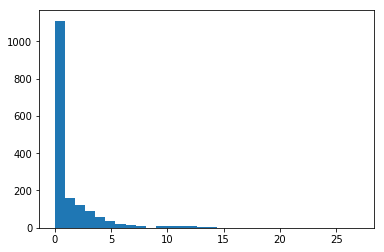

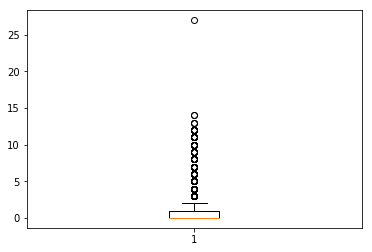

In [17]:
# check FeatureCount for outliers

# histogram
plt.hist(df_museum['FeatureCount'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['FeatureCount'])
plt.show()

In [18]:
# what museum has > 25 feature counts?
df_museum[['MuseumName','FeatureCount']][df_museum['FeatureCount'] > 25]

,MuseumName,FeatureCount
1225,Hagia Sophia Museum / Church (Ayasofya),27


It appears that being featured is uncommon, so any museums that have been featured more than once are outliers in the plot. However removing all of these would remove the data of value from this column. The main outlier is the entry that was featured 27 times, but upon further inspection, it makes sense because this is a very popular museum, and has recently been featured in a popular book series.

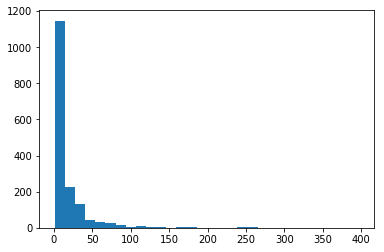

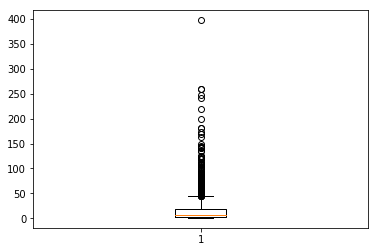

In [19]:
# check Rank for outliers

# histogram
plt.hist(df_museum['Rank'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['Rank'])
plt.show()

In [20]:
# what museum has a ranking > 300?
df_museum[['MuseumName','Rank','TotalThingsToDo','City']][df_museum['Rank'] > 300]

,MuseumName,Rank,TotalThingsToDo,City
188,Museum of Sex,397,1028,New York City


This ranking makes sense given the type of museum and the total number of things to do in this city. I will next plot the Rank on a log scale to evaluate the other outliers.

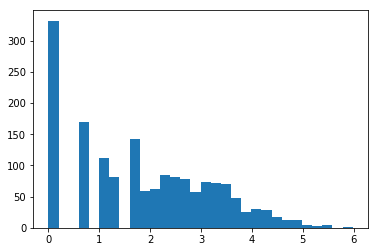

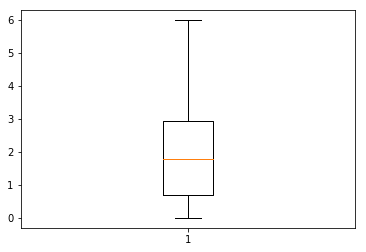

In [21]:
# check Rank on a log scale for outliers

# histogram
plt.hist(np.log(df_museum['Rank']), bins = 30)
plt.show()

# box plot
plt.boxplot(np.log(df_museum['Rank']))
plt.show()

The distribution on a logarithmic scale is reasonable so I won't remove any data from the Rank column.

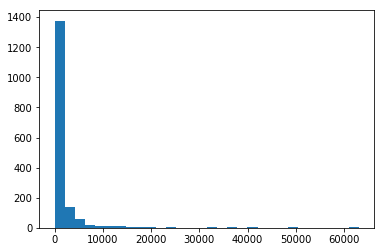

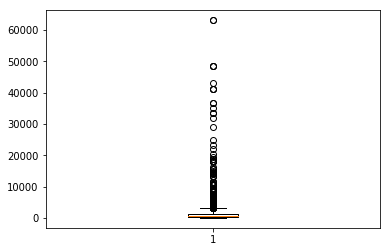

In [22]:
# check ReviewCount for outliers

# histogram
plt.hist(df_museum['ReviewCount'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['ReviewCount'])
plt.show()

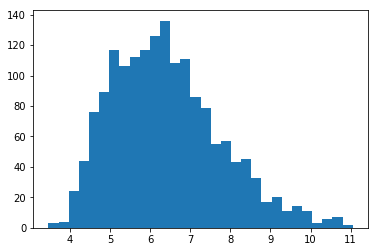

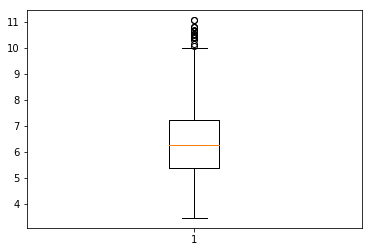

In [23]:
# check ReviewCount for outliers on log scale

# histogram
plt.hist(np.log(df_museum['ReviewCount']), bins = 30)
plt.show()

# box plot
plt.boxplot(np.log(df_museum['ReviewCount']))
plt.show()

In [24]:
# what museums are the remaining outliers - with 30 000+ reviews (log(30000)~=10)?
df_museum[['MuseumName','ReviewCount','Country']][np.log(df_museum['ReviewCount']) > 10]

,MuseumName,ReviewCount,Country
1,The Metropolitan Museum of Art,36627,USA
5,The National 9/11 Memorial & Museum,48437,USA
1015,British Museum,41295,England
1016,Rijksmuseum,25042,The Netherlands
1017,The Metropolitan Museum of Art,36628,USA
1018,Musee d'Orsay,43037,France
1020,Van Gogh Museum,33383,The Netherlands
1025,Prado National Museum,31900,Spain
1030,The National 9/11 Memorial & Museum,48438,USA
1037,Musee du Louvre,63112,France


The log plot of the review counts shows a reasonable distribution. Additionally, all of these museums with very large numbers of reviews make sense, because they are all highly popular worldwide. However, it appears that there are duplicates remaining in the data.

In [25]:
# continue duplicate analysis
print(df_museum[df_museum.duplicated()])

Empty DataFrame
Columns: [Address, Description, FeatureCount, Fee, Longitude, Latitude, LengthOfVisit, MuseumName, PhoneNum, Rank, Rating, ReviewCount, TotalThingsToDo, Country, City, State]
Index: []


As there are no more fully duplicated rows, I will look for anomalies by inspecting duplicates in the MuseumName column.

In [26]:
# check for duplicates specifically in the MuseumName column
remaining_duplicates = df_museum[df_museum.duplicated(subset='MuseumName',keep=False)].sort_values(by='MuseumName')
remaining_duplicates

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo,Country,City,State
1022,"Dionysiou Areopagitou 15 | Makriyianni, Athens...","Modern, uptodate building on the foot of the A...",11,Yes,23.73,37.97,2-3 hours,Acropolis Museum,30 210 9000900,1,4.50,18258,324,Greece,NaN,NaN
1736,"Dionysiou Areopagitou 15 | Makriyianni, Athens...","Modern, uptodate building on the foot of the A...",11,Yes,23.73,37.97,2-3 hours,Acropolis Museum,30 210 9000900,1,4.50,18259,324,Greece,NaN,NaN
1329,"625 C St, Anchorage, AK 99501-3544","Alaska's largest museum focusing on art, histo...",0,NaN,-149.88,61.22,1-2 hours,Anchorage Museum at Rasmuson Center,907-929-9201,4,4.50,1776,212,USA,Anchorage,AK
97,"625 C St, Anchorage, AK 99501-3544","Alaska's largest museum focusing on art, histo...",0,NaN,-149.88,61.22,1-2 hours,Anchorage Museum at Rasmuson Center,907-929-9201,4,4.50,1775,212,USA,Anchorage,AK
1448,"400 Grand Blvd, Kansas City, MO 64106-1111",The Arabia Steamboat Museum is a favorite Kans...,0,NaN,-94.58,39.11,NaN,Arabia Steamboat Museum,+1 816 471 1856,3,4.50,1331,147,USA,Kansas City,MO
136,"400 Grand Blvd, Kansas City, MO 64106-1111",The Arabia Steamboat Museum is a favorite Kans...,0,NaN,-94.58,39.11,NaN,Arabia Steamboat Museum,+1 816 471 1856,3,4.50,1330,147,USA,Kansas City,MO
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614,USA,Chicago,IL
1087,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15533,614,USA,Chicago,IL
1729,"Great Russell Street, London WC1B 3DG, England","A museum of the world, for the world. Discover...",6,No,-0.13,51.52,2-3 hours,British Museum,+44 (0)20 7323 8299,1,4.50,41298,1443,England,NaN,NaN
1015,"Great Russell Street, London WC1B 3DG, England","A museum of the world, for the world. Discover...",6,No,-0.13,51.52,2-3 hours,British Museum,+44 (0)20 7323 8299,1,4.50,41295,1443,England,NaN,NaN


Upon inspection of the duplicate data, I see two anomalies:
1. For many duplicate sets, all data is identical except for the ReviewCount which is incremented by ~1-2. My assumption is that the second entry received a few more reviews in the time between when the entries were scraped from the web, so I will keep the entry with the highest review count - which corresponds to the entry with the highest index (though the difference is so minimal it likely wouldn't matter either way).
2. There are several museums that have different addresses/other data, which likely indicates multiple franchise locations. However, the secondary datasets only list MuseumName, and have no address or other information that could be used to map the duplicate entries correctly - e.g. no way to know which traveler types correspond to the Hollywood Wax Museum in LA vs the one in Myrtle Beach (well, reviews could be associated by ReviewCount but traveler types and museum category have no association possible). Thus, I will have to completely drop these museums from the dataset.

In [27]:
# remove duplicates where only ReviewCount differs (will use MuseumName and Address for simplicity)
df_museum.drop_duplicates(['MuseumName','Address'], keep='last', inplace=True)

# remove all remaining duplicates entirely (i.e. museums with multiple locations)
df_museum.drop_duplicates(['MuseumName'], keep=False, inplace=True)

df_museum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1593 entries, 7 to 2025
Data columns (total 16 columns):
Address            1593 non-null object
Description        1153 non-null object
FeatureCount       1593 non-null int64
Fee                232 non-null object
Longitude          1549 non-null float64
Latitude           1549 non-null float64
LengthOfVisit      563 non-null object
MuseumName         1593 non-null object
PhoneNum           1587 non-null object
Rank               1593 non-null int64
Rating             1593 non-null float64
ReviewCount        1593 non-null int32
TotalThingsToDo    1593 non-null int32
Country            1593 non-null object
City               1001 non-null object
State              1001 non-null object
dtypes: float64(3), int32(2), int64(2), object(9)
memory usage: 199.1+ KB


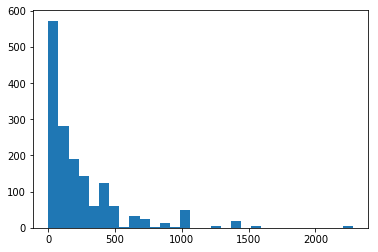

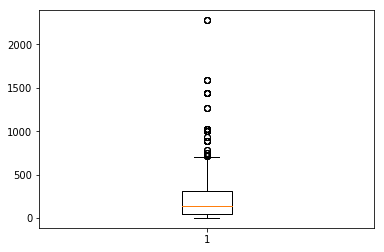

In [28]:
# check TotalThingsToDo for outliers

# histogram
plt.hist(df_museum['TotalThingsToDo'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['TotalThingsToDo'])
plt.show()

In [29]:
# what location has > 2000 things to do?

df_museum[['MuseumName','TotalThingsToDo','Country']][df_museum['TotalThingsToDo'] > 2000]

,MuseumName,TotalThingsToDo,Country
1661,Pushkin State Museum of Fine Arts,2279,Russia
1828,Jewish Museum and Tolerance Center,2279,Russia
1859,Borodino Battle Museum Panorama,2279,Russia
1914,Experimentanium,2279,Russia
1944,The State Central Museum of Contemporary Histo...,2279,Russia


This data point makes sense because Russia is a huge country with many attractions.

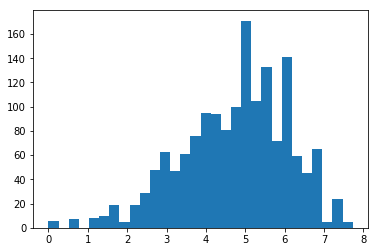

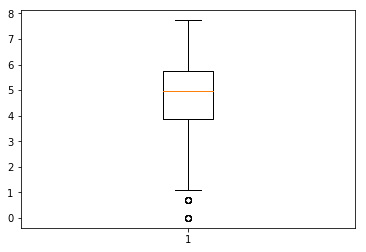

In [30]:
# check TotalThingsToDo for outliers on a log scale

# histogram
plt.hist(np.log(df_museum['TotalThingsToDo']), bins = 30)
plt.show()

# box plot
plt.boxplot(np.log(df_museum['TotalThingsToDo']))
plt.show()

In [31]:
# what locations have < 3 things to do (log(3) ~= 1)?

df_museum[['MuseumName','TotalThingsToDo','Country','Address']][np.log(df_museum['TotalThingsToDo']) < 1]

,MuseumName,TotalThingsToDo,Country,Address
185,Walton's Mountain Museum,2,USA,"Route 617, Schuyler, VA"
591,Loretta Lynn's Ranch,2,USA,"44 Hurricane Mills Rd, Hurricane Mills, TN 370..."
654,Buford Pusser Home and Museum,1,USA,"342 Pusser St, Adamsville, TN 38310-2338"
701,Intel Corp and Museum,2,USA,"2200 Mission College Blvd, Santa Clara, CA 950..."
763,Sky City Cultural Center & Haak'u Museum,1,USA,"Haaku Rd, Pueblo of Acoma, NM 87034"
804,Patton Museum of Cavalry and Armor,2,USA,"Fort Knox, KY"
994,Idaho Potato Museum,1,USA,"130 NW Main St, Blackfoot, ID 83221-2239"
1049,The Tank Museum,1,England,"Bovington, Wareham BH20 6JG, England"
1598,Normandy Tank Museum,1,France,"Avenue du Cotentin | PA La Fourchette, 50500 C..."
1611,December 44 Historical Museum,1,Belgium,"Rue de l'Eglise 7, La Gleize 4987, Belgium"


These data points also make sense because they are in smaller areas/towns that likely wouldn't have many attractions.

#### Traveler ratings data:

In [32]:
# inspect ratings data
print('US traveler ratings')
print(df_ratings_US.columns)
print(df_ratings_US.describe())
print(df_ratings_US.info())
print(df_ratings_US.head())
print('')
print('World traveler ratings')
print(df_ratings_world.columns)
print(df_ratings_world.describe())
print(df_ratings_world.info())
print(df_ratings_world.head())

US traveler ratings
Index(['Gettysburg Heritage Center', 'Hudson River Museum',
       'The Aurora Ice Museum', 'Chrysler Museum of Art', 'Pink Palace Museum',
       'Gettysburg Seminary Ridge Museum', 'Oklahoma Railway Museum',
       'Ships of the Sea Maritime Museum', 'LBJ Presidential Library',
       'Museum Mile',
       ...
       'New England Air Museum',
       'GulfQuest National Maritime Museum of the Gulf of Mexico',
       'Mohave Museum of History and Arts', 'Ellis Island',
       'San Diego Model Railroad Museum', 'Superstition Mountain Museum',
       'Please Touch Museum', 'McClung Museum of Natural History and Culture',
       'NSU Art Museum', 'Morikami Museum & Japanese Gardens'],
      dtype='object', length=1007)
       Gettysburg Heritage Center  Hudson River Museum  The Aurora Ice Museum  \
count                        5.00                 5.00                   5.00   
mean                        45.20                13.60                  96.80   
std        

       Musical Museum  \
count            5.00   
mean            47.00   
std             30.41   
min              4.00   
25%             27.00   
50%             62.00   
75%             65.00   
max             77.00   

       Museum of Natural History (Museum d'Histoire naturelle)  \
count                                               5.00         
mean                                               27.20         
std                                                20.56         
min                                                 6.00         
25%                                                17.00         
50%                                                21.00         
75%                                                32.00         
max                                                60.00         

       National Football Museum  Escher in Het Paleis (Escher in the Palace)  \
count                      5.00                                         5.00   
mean               

The museum names have been loaded in as the columns, but it would be better to have them as rows instead.

In [33]:
# transpose traveler ratings data
df_ratings_US = df_ratings_US.T
df_ratings_world = df_ratings_world.T

print(df_ratings_US.head())
print(df_ratings_world.head())

                              0    1   2   3    4
Gettysburg Heritage Center   88   86  17   2   33
Hudson River Museum          25   22   2   4   15
The Aurora Ice Museum       132  204  35   7  106
Chrysler Museum of Art      133  155  52  17   93
Pink Palace Museum          163   84  12   7   41
                                                      0    1    2   3    4
Musical Museum                                       62   65   27   4   77
Museum of Natural History (Museum d'Histoire na...   60   32   17   6   21
National Football Museum                            617  451  178  42  308
Escher in Het Paleis (Escher in the Palace)         145  275  113  34  173
Djurgarden                                          208  445  130  41  203


In [34]:
# concatenate dataframes

df_traveler_ratings = pd.concat([df_ratings_US, df_ratings_world]).reset_index()
print(df_traveler_ratings.info())
df_traveler_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 6 columns):
index    1889 non-null object
0        1889 non-null object
1        1889 non-null object
2        1889 non-null object
3        1889 non-null object
4        1889 non-null object
dtypes: object(6)
memory usage: 88.6+ KB
None


,index,0,1,2,3,4
0,Gettysburg Heritage Center,88,86,17,2,33
1,Hudson River Museum,25,22,2,4,15
2,The Aurora Ice Museum,132,204,35,7,106
3,Chrysler Museum of Art,133,155,52,17,93
4,Pink Palace Museum,163,84,12,7,41


In [35]:
# drop duplicate data
df_traveler_ratings.drop_duplicates(keep='first', inplace=True)
print(df_traveler_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1631 entries, 0 to 1888
Data columns (total 6 columns):
index    1631 non-null object
0        1631 non-null object
1        1631 non-null object
2        1631 non-null object
3        1631 non-null object
4        1631 non-null object
dtypes: object(6)
memory usage: 89.2+ KB
None


In [36]:
# drop duplicate museum names, keeping the last entry (assumed to be the most up-to-date, as per rationale for museum info data)
df_traveler_ratings.drop_duplicates(subset='index', keep='last', inplace=True)
print(df_traveler_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 6 columns):
index    1603 non-null object
0        1603 non-null object
1        1603 non-null object
2        1603 non-null object
3        1603 non-null object
4        1603 non-null object
dtypes: object(6)
memory usage: 87.7+ KB
None


There are now 1603 unique entries, which is more than the museum info data (1593) - this makes sense because 10 museums were removed completely (i.e. ones with multiple locations). These extras will be discarded when I merge the final dataset.

In [37]:
# fix column names (from data source we know the corresponding names)
df_traveler_ratings.columns = ['MuseumName', 'Excellent','Very Good','Average','Poor','Terrible']
df_traveler_ratings.head()

,MuseumName,Excellent,Very Good,Average,Poor,Terrible
0,Gettysburg Heritage Center,88,86,17,2,33
1,Hudson River Museum,25,22,2,4,15
2,The Aurora Ice Museum,132,204,35,7,106
3,Chrysler Museum of Art,133,155,52,17,93
4,Pink Palace Museum,163,84,12,7,41


#### Traveler types data:

In [38]:
# inspect travelers data
print('US traveler types')
print(df_travelers_US.columns)
print(df_travelers_US.describe())
print(df_travelers_US.info())
print(df_travelers_US.head())
print('')
print('World traveler types')
print(df_travelers_world.columns)
print(df_travelers_world.describe())
print(df_travelers_world.info())
print(df_travelers_world.head())

US traveler types
Index(['Gettysburg Heritage Center', 'Hudson River Museum',
       'The Aurora Ice Museum', 'Chrysler Museum of Art', 'Pink Palace Museum',
       'Gettysburg Seminary Ridge Museum', 'Oklahoma Railway Museum',
       'Ships of the Sea Maritime Museum', 'LBJ Presidential Library',
       'Museum Mile',
       ...
       'New England Air Museum',
       'GulfQuest National Maritime Museum of the Gulf of Mexico',
       'Mohave Museum of History and Arts', 'Ellis Island',
       'San Diego Model Railroad Museum', 'Superstition Mountain Museum',
       'Please Touch Museum', 'McClung Museum of Natural History and Culture',
       'NSU Art Museum', 'Morikami Museum & Japanese Gardens'],
      dtype='object', length=1007)
       Gettysburg Heritage Center  Hudson River Museum  The Aurora Ice Museum  \
count                        5.00                 5.00                   5.00   
mean                        45.20                13.60                  96.80   
std          

       Musical Museum  \
count            5.00   
mean            47.00   
std             30.41   
min              4.00   
25%             27.00   
50%             62.00   
75%             65.00   
max             77.00   

       Museum of Natural History (Museum d'Histoire naturelle)  \
count                                               5.00         
mean                                               27.20         
std                                                20.56         
min                                                 6.00         
25%                                                17.00         
50%                                                21.00         
75%                                                32.00         
max                                                60.00         

       National Football Museum  Escher in Het Paleis (Escher in the Palace)  \
count                      5.00                                         5.00   
mean               

In [39]:
# transpose traveler types data (same as for ratings)
df_travelers_US = df_travelers_US.T
df_travelers_world = df_travelers_world.T

print(df_travelers_US.head())
print(df_travelers_US.info())
print(df_travelers_world.head())
print(df_travelers_world.info())

                              0    1   2   3    4
Gettysburg Heritage Center   88   86  17   2   33
Hudson River Museum          25   22   2   4   15
The Aurora Ice Museum       132  204  35   7  106
Chrysler Museum of Art      133  155  52  17   93
Pink Palace Museum          163   84  12   7   41
<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, Gettysburg Heritage Center to Morikami Museum & Japanese Gardens
Data columns (total 5 columns):
0    1007 non-null object
1    1007 non-null object
2    1007 non-null object
3    1007 non-null object
4    1007 non-null object
dtypes: object(5)
memory usage: 87.2+ KB
None
                                                      0    1    2   3    4
Musical Museum                                       62   65   27   4   77
Museum of Natural History (Museum d'Histoire na...   60   32   17   6   21
National Football Museum                            617  451  178  42  308
Escher in Het Paleis (Escher in the Palace)         145  275  113  3

In [40]:
# concatenate dataframes, drop duplicates and fix column names similar to traveler ratings data

# concatenate dataframes
df_traveler_types = pd.concat([df_travelers_US, df_travelers_world]).reset_index()

# drop duplicate data
df_traveler_types.drop_duplicates(keep='first', inplace=True)

# drop duplicate museums with different entries (keep last, assumed most up-to-date)
df_traveler_types.drop_duplicates(subset='index', keep='last', inplace=True)

# fix column names (from data source we know the corresponding names)
df_traveler_types.columns = ['MuseumName', 'Families','Couples','Solo','Business','Friends']

print(df_traveler_types.info())
df_traveler_ratings.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 6 columns):
MuseumName    1603 non-null object
Families      1603 non-null object
Couples       1603 non-null object
Solo          1603 non-null object
Business      1603 non-null object
Friends       1603 non-null object
dtypes: object(6)
memory usage: 87.7+ KB
None


,MuseumName,Excellent,Very Good,Average,Poor,Terrible
0,Gettysburg Heritage Center,88,86,17,2,33
1,Hudson River Museum,25,22,2,4,15
2,The Aurora Ice Museum,132,204,35,7,106
3,Chrysler Museum of Art,133,155,52,17,93
4,Pink Palace Museum,163,84,12,7,41


No missing entries and same number of museums as traveler ratings data.

#### Museum category data:

This one is a bit different because the number of categories varies per museum. So I had to load the data as a dict, and will need to do a conversion and some manipulations to get a nice dataframe.


In [41]:
# convert dict to dataframe
df_categories_US = pd.DataFrame.from_dict(json_category_US, orient = 'index')
df_categories_world = pd.DataFrame.from_dict(json_category_world, orient = 'index')

#inspect museum category data
print('US museum categories')
print(df_categories_US.columns)
print(df_categories_US.describe())
print(df_categories_US.info())
print(df_categories_US.head())
print('')
print('World museum categories')
print(df_categories_world.columns)
print(df_categories_world.describe())
print(df_categories_world.info())
print(df_categories_world.head())

US museum categories
RangeIndex(start=0, stop=9, step=1)
                        0        1        2        3        4        5  \
count                1007     1003      242      128       49       22   
unique                 42       35       31       21       12        6   
top     Specialty Museums  Museums  Museums  Museums  Museums  Museums   
freq                  404      749      132       65       17       10   

              6                   7                   8  
count         7                   4                   2  
unique        4                   3                   2  
top     Museums  Outdoor Activities  Sights & Landmarks  
freq          3                   2                   1  
<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, Gettysburg Heritage Center to Morikami Museum & Japanese Gardens
Data columns (total 9 columns):
0    1007 non-null object
1    1003 non-null object
2    242 non-null object
3    128 non-null object
4    49 non-null object


In [42]:
# concatenate dataframes

df_categories = pd.concat([df_categories_US, df_categories_world]).reset_index()
print(df_categories.info())
df_categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 10 columns):
index    1889 non-null object
0        1889 non-null object
1        1883 non-null object
2        448 non-null object
3        239 non-null object
4        91 non-null object
5        48 non-null object
6        14 non-null object
7        6 non-null object
8        2 non-null object
dtypes: object(10)
memory usage: 147.7+ KB
None


,index,0,1,2,3,4,5,6,7,8
0,Gettysburg Heritage Center,History Museums,Museums,None,None,None,None,None,None,None
1,Hudson River Museum,Specialty Museums,Museums,None,None,None,None,None,None,None
2,The Aurora Ice Museum,Specialty Museums,Museums,None,None,None,None,None,None,None
3,Chrysler Museum of Art,Art Museums,Museums,None,None,None,None,None,None,None
4,Pink Palace Museum,History Museums,Natural History Museums,Museums,None,None,None,None,None,None


In [43]:
# drop duplicates
df_categories.drop_duplicates(keep='first', inplace=True)

# drop duplicate museums (keep last for consistency with other data)
df_categories.drop_duplicates(subset='index', keep='last', inplace=True)

df_categories.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 10 columns):
index    1603 non-null object
0        1603 non-null object
1        1598 non-null object
2        377 non-null object
3        197 non-null object
4        76 non-null object
5        38 non-null object
6        11 non-null object
7        5 non-null object
8        2 non-null object
dtypes: object(10)
memory usage: 137.8+ KB


Same number of unique museums as traveler ratings and traveler type data.

In [44]:
# restructure data to have museum categories as columns with flags per museum (hacked one hot encoding)

# melt dataframe to lines per museum, category pairs
df_categories = pd.melt(df_categories, id_vars=['index'], value_vars=[0,1,2,3,4,5,6,7,8])

print(df_categories.head())

# pivot counts of museum categories per museum
df_categories = df_categories.pivot_table(index='index', columns='value', aggfunc='count', fill_value=0)

df_categories.head()


                        index variable              value
0  Gettysburg Heritage Center        0    History Museums
1         Hudson River Museum        0  Specialty Museums
2       The Aurora Ice Museum        0  Specialty Museums
3      Chrysler Museum of Art        0        Art Museums
4          Pink Palace Museum        0    History Museums


variable                          \
value                                   Ancient Ruins Architectural Buildings   
index                                                                           
1940 Air Terminal Museum                            0                       0   
21c Museum Hotel                                    0                       0   
21st Century Museum of Contemporary Art             0                       0   
45th Infantry Division Museum                       0                       0   
911 Ground Zero Tour                                0                       0   

                                                                         \
value                                   Arenas & Stadiums Art Galleries   
index                                                                     
1940 Air Terminal Museum                                0             0   
21c Museum Hotel                                        0             0   
21st Century Museum of Contemporary Art                 0             0   
45th Infantry Division Museum                           0             0   
911 Ground Zero Tour                                    0             0   

                                                                              \
value                                   Art Museums Auto Race Tracks Ballets   
index                                                                          
1940 Air Terminal Museum                          0                0       0   
21c Museum Hotel                                  0                0       0   
21st Century Museum of Contemporary Art           1                0       0   
45th Infantry Division Museum                     0                0       0   
911 Ground Zero Tour                              0                0       0   

                                                                    \
value                                   Battlefields Biking Trails   
index                                                                
1940 Air Terminal Museum                           0             0   
21c Museum Hotel                                   0             0   
21st Century Museum of Contemporary Art            0             0   
45th Infantry Division Museum                      0             0   
911 Ground Zero Tour                               0             0   

                                                         ...           \
value                                   Bodies of Water  ... Tramways   
index                                                    ...            
1940 Air Terminal Museum                              0  ...        0   
21c Museum Hotel                                      0  ...        0   
21st Century Museum of Contemporary Art               0  ...        0   
45th Infantry Division Museum                         0  ...        0   
911 Ground Zero Tour                                  0  ...        0   

                                                                           \
value                                   Transportation Traveler Resources   
index                                                                       
1940 Air Terminal Museum                             0                  0   
21c Museum Hotel                                     0                  0   
21st Century Museum of Contemporary Art              0                  0   
45th Infantry Division Museum                        0                  0   
911 Ground Zero Tour                                 0                  0   

                                                                          \
value                                   Valleys Visitor Centers Volcanos   
index                                                                      
1940 Air Terminal Museum                      0               0        0   
21c Museum Hotel                              0               0        0   
21st Centur

In [45]:
# concatenate dataframes

df_categories = pd.concat([df_categories_US, df_categories_world]).reset_index()
print(df_categories.info())
df_categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 10 columns):
index    1889 non-null object
0        1889 non-null object
1        1883 non-null object
2        448 non-null object
3        239 non-null object
4        91 non-null object
5        48 non-null object
6        14 non-null object
7        6 non-null object
8        2 non-null object
dtypes: object(10)
memory usage: 147.7+ KB
None


,index,0,1,2,3,4,5,6,7,8
0,Gettysburg Heritage Center,History Museums,Museums,None,None,None,None,None,None,None
1,Hudson River Museum,Specialty Museums,Museums,None,None,None,None,None,None,None
2,The Aurora Ice Museum,Specialty Museums,Museums,None,None,None,None,None,None,None
3,Chrysler Museum of Art,Art Museums,Museums,None,None,None,None,None,None,None
4,Pink Palace Museum,History Museums,Natural History Museums,Museums,None,None,None,None,None,None


In [46]:
# restructure data to have museum categories as columns (hacked one hot encoding)

# melt dataframe to lines per museum, category pairs
df_categories = pd.melt(df_categories, id_vars=['index'], value_vars=[0,1,2,3,4,5,6,7,8])

print(df_categories.head())

# pivot counts of museum categories per museum
df_categories = df_categories.pivot_table(index='index', columns='value', aggfunc='count', fill_value=0)

df_categories.head()

                        index variable              value
0  Gettysburg Heritage Center        0    History Museums
1         Hudson River Museum        0  Specialty Museums
2       The Aurora Ice Museum        0  Specialty Museums
3      Chrysler Museum of Art        0        Art Museums
4          Pink Palace Museum        0    History Museums


variable                          \
value                                   Ancient Ruins Architectural Buildings   
index                                                                           
1940 Air Terminal Museum                            0                       0   
21c Museum Hotel                                    0                       0   
21st Century Museum of Contemporary Art             0                       0   
45th Infantry Division Museum                       0                       0   
911 Ground Zero Tour                                0                       0   

                                                                         \
value                                   Arenas & Stadiums Art Galleries   
index                                                                     
1940 Air Terminal Museum                                0             0   
21c Museum Hotel                                        0             0   
21st Century Museum of Contemporary Art                 0             0   
45th Infantry Division Museum                           0             0   
911 Ground Zero Tour                                    0             0   

                                                                              \
value                                   Art Museums Auto Race Tracks Ballets   
index                                                                          
1940 Air Terminal Museum                          0                0       0   
21c Museum Hotel                                  0                0       0   
21st Century Museum of Contemporary Art           1                0       0   
45th Infantry Division Museum                     0                0       0   
911 Ground Zero Tour                              0                0       0   

                                                                    \
value                                   Battlefields Biking Trails   
index                                                                
1940 Air Terminal Museum                           0             0   
21c Museum Hotel                                   0             0   
21st Century Museum of Contemporary Art            0             0   
45th Infantry Division Museum                      0             0   
911 Ground Zero Tour                               0             0   

                                                         ...           \
value                                   Bodies of Water  ... Tramways   
index                                                    ...            
1940 Air Terminal Museum                              0  ...        0   
21c Museum Hotel                                      0  ...        0   
21st Century Museum of Contemporary Art               0  ...        0   
45th Infantry Division Museum                         0  ...        0   
911 Ground Zero Tour                                  0  ...        0   

                                                                           \
value                                   Transportation Traveler Resources   
index                                                                       
1940 Air Terminal Museum                             0                  0   
21c Museum Hotel                                     0                  0   
21st Century Museum of Contemporary Art              0                  0   
45th Infantry Division Museum                        0                  0   
911 Ground Zero Tour                                 0                  0   

                                                                          \
value                                   Valleys Visitor Centers Volcanos   
index                                                                      
1940 Air Terminal Museum                      0               0        0   
21c Museum Hotel                              0               0        0   
21st Centur

In [47]:
# flatten multi-index and reindex
df_categories.columns = df_categories.columns.droplevel(0)
df_categories.reset_index(inplace=True)

# rename museum column
df_categories.rename(columns={'index':'MuseumName'}, inplace=True)

print("Museum Categories")
print(df_categories.columns)

df_categories.head()

Museum Categories
Index(['MuseumName', 'Ancient Ruins', 'Architectural Buildings',
       'Arenas & Stadiums', 'Art Galleries', 'Art Museums', 'Auto Race Tracks',
       'Ballets', 'Battlefields', 'Biking Trails', 'Bodies of Water',
       'Bridges', 'Castles', 'Cemeteries', 'Children's Museums', 'City Tours',
       'Classes & Workshops', 'Coffeehouses', 'Concerts & Shows',
       'Cultural Tours', 'Educational sites', 'Factory Tours',
       'Flea & Street Markets', 'Food & Drink', 'Fun & Games',
       'Game & Entertainment Centers', 'Gardens', 'Geologic Formations',
       'Gift & Specialty Shops', 'Government Buildings', 'Historic Sites',
       'Historic Walking Areas', 'Historical & Heritage Tours',
       'History Museums', 'Islands', 'Lessons & Workshops', 'Libraries',
       'Lighthouses', 'Literary, Art & Music Tours', 'Lookouts',
       'Military Bases & Facilities', 'Military Museums', 'Mines',
       'Monuments & Statues', 'Movie Theaters', 'Museums', 'National Parks',
  

value,MuseumName,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,...,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums
0,1940 Air Terminal Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21c Museum Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21st Century Museum of Contemporary Art,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45th Infantry Division Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,911 Ground Zero Tour,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Tag cloud data:

Same process as museum categories

In [48]:
# convert dict to dataframe
df_tags_US = pd.DataFrame.from_dict(json_tags_US, orient = 'index')
df_tags_world = pd.DataFrame.from_dict(json_tags_world, orient = 'index')

#inspect museum category data
print('US tag clouds')
print(df_tags_US.columns)
print(df_tags_US.describe())
print(df_tags_US.info())
print(df_tags_US.head())
print('')
print('World tag clouds')
print(df_tags_world.columns)
print(df_tags_world.describe())
print(df_tags_world.info())
print(df_tags_world.head())

US tag clouds
RangeIndex(start=0, stop=20, step=1)
                          0          1           2           3           4   \
count                    997        997         997         997         997   
unique                   663        697         707         748         773   
top     permanent collection  gift shop  on display  on display  on display   
freq                      40         23          31          23          19   

                5                 6           7           8           9   \
count          994               993         991         988         985   
unique         765               778         751         739         712   
top     on display  special exhibits  on display  on display  on display   
freq            24                15          29          21          32   

                10          11          12          13          14  \
count          981         979         977         973         968   
unique         718         658  

In [49]:
# concatenate dataframes
df_tags = pd.concat([df_tags_US, df_tags_world]).reset_index()

# restructure data to have tags as columns (i.e. hacked one hot encoding)

# melt dataframe to lines per museum, tag pairs
df_tags = pd.melt(df_tags, id_vars=['index'], value_vars=list(range(19)))

# pivot counts of tags per museum
df_tags = df_tags.pivot_table(index='index', columns='value', aggfunc='count', fill_value=0)

# flatten multi-index and reindex
df_tags.columns = df_tags.columns.droplevel(0)
df_tags.reset_index(inplace=True)

# rename museum column
df_tags.rename(columns={'index':'MuseumName'}, inplace=True)

print("Tags")
print(df_tags.columns)

df_tags.head()

Tags
Index(['MuseumName', '2500ft', '3aed', '50rb', '8tl', '91st', '9euros',
       'a bit overpriced', 'a couple times', 'a day in the life',
       ...
       'zimmerman house', 'zip code', 'zip line', 'zombie outbreak',
       'zombie tour', 'zoo', 'zoo area', 'zoom', 'zurich card', 'zz'],
      dtype='object', name='value', length=10519)


value,MuseumName,2500ft,3aed,50rb,8tl,91st,9euros,a bit overpriced,a couple times,a day in the life,...,zimmerman house,zip code,zip line,zombie outbreak,zombie tour,zoo,zoo area,zoom,zurich card,zz
0,1940 Air Terminal Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21c Museum Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21st Century Museum of Contemporary Art,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45th Infantry Division Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,911 Ground Zero Tour,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are way too many tags here, so I will inspect further.

value
on display              939
gift shop               526
all ages                351
rainy day               330
couple of hours         306
special exhibits        258
permanent collection    209
free admission          205
few hours               198
two hours               192
well worth a visit      170
beautiful building      167
worth a visit           161
great collection        160
audio guide             155
exhibits                148
hands on activities     145
great exhibits          143
interesting exhibits    142
interactive exhibits    140
great for kids          139
entrance fee            122
information             118
interactive displays    114
traveling exhibits      113
guided tour             108
great place to visit    100
kids and adults          99
whole family             97
his life                 96
                       ... 
modest admission fee      1
mizner park               1
modern addition           1
mizrahi                   1
mo chit       

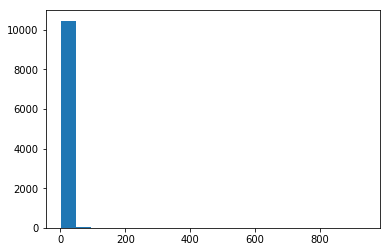

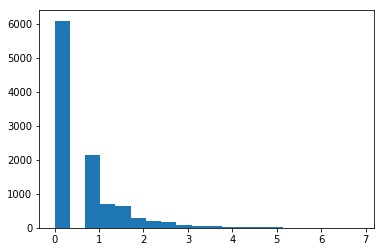

In [50]:
# list tags in descending order
df_tag_counts = df_tags.drop('MuseumName', axis=1).sum().sort_values(ascending=False)
print(df_tag_counts)

# histogram
plt.hist(df_tag_counts, bins = 20)
plt.show()

# histogram, log scale
plt.hist(np.log(df_tag_counts), bins = 20)
plt.show()

The vast majority of tags have very few entries, but a few have many. I will only focus on the top-used tags.

In [51]:
# find tags used at least 50 times
frequent_tags = df_tag_counts[df_tag_counts.values > 50]
frequent_tags

value
on display              939
gift shop               526
all ages                351
rainy day               330
couple of hours         306
special exhibits        258
permanent collection    209
free admission          205
few hours               198
two hours               192
well worth a visit      170
beautiful building      167
worth a visit           161
great collection        160
audio guide             155
exhibits                148
hands on activities     145
great exhibits          143
interesting exhibits    142
interactive exhibits    140
great for kids          139
entrance fee            122
information             118
interactive displays    114
traveling exhibits      113
guided tour             108
great place to visit    100
kids and adults          99
whole family             97
his life                 96
well worth the visit     94
civil war                93
amazing collection       92
audio tour               89
van gogh                 87
take your time

In [52]:
# TO DO
# ** merge and save tidy dataset

In [53]:
frequent_tags_list = list(frequent_tags.index)
df_frequent_tags = df_tags[['MuseumName'] + frequent_tags_list]
df_frequent_tags.head()

value,MuseumName,on display,gift shop,all ages,rainy day,couple of hours,special exhibits,permanent collection,free admission,few hours,...,own pace,self guided tour,private collection,moving experience,artifacts,three hours,galleries,lots of history,history buff,across the street
0,1940 Air Terminal Museum,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21c Museum Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21st Century Museum of Contemporary Art,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,45th Infantry Division Museum,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,911 Ground Zero Tour,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Merge data

In [54]:
# initialize merged dataset with columns of interest from museum info data

df_merged = df_museum[['MuseumName','Address','Country','City','State','Rating','ReviewCount','FeatureCount','Rank','TotalThingsToDo']].reset_index(drop=True)
df_merged.head()

,MuseumName,Address,Country,City,State,Rating,ReviewCount,FeatureCount,Rank,TotalThingsToDo
0,The Field Museum,"1400 S Lake Shore Dr, Chicago, IL 60605-2827",USA,Chicago,IL,4.50,5500,4,9,614
1,Smithsonian National Museum of Natural History,"10th Street and Constitution Ave, Washington D...",USA,Washington DC,DC,4.50,7640,7,12,398
2,American Museum of Natural History,"79th Street and Central Park West, New York Ci...",USA,New York City,NY,4.50,13992,11,32,1028
3,National Naval Aviation Museum,"1750 Radford Blvd, NAS Pensacola, Pensacola, F...",USA,Pensacola,FL,5.00,4057,0,1,103
4,National Mississippi River Museum & Aquarium,"350 E 3rd St, Port of Dubuque, Dubuque, IA 520...",USA,Dubuque,IA,4.50,1036,0,2,62


I excluded the following fields because they were either not relevant for further analysis or had too many missing values:
Description, Fee, Longitude, Latitude, LengthOfVisit, PhoneNum

I kept the address field because it contains more granular location information than country for non-US entries

In [55]:
# merge other datasets

# merge traveler ratings data
df_merged = df_merged.merge(df_traveler_ratings, on='MuseumName', how='left')

# merge traveler types data
df_merged = df_merged.merge(df_traveler_types, on='MuseumName', how='left')

# merge museum category data
df_merged = df_merged.merge(df_categories, on='MuseumName', how='left')

# merge tag data
df_merged = df_merged.merge(df_frequent_tags, on='MuseumName', how='left')

print(df_merged.shape)
df_merged.head()

(1593, 163)


,MuseumName,Address,Country,City,State,Rating,ReviewCount,FeatureCount,Rank,TotalThingsToDo,...,own pace,self guided tour,private collection,moving experience,artifacts,three hours,galleries,lots of history,history buff,across the street
0,The Field Museum,"1400 S Lake Shore Dr, Chicago, IL 60605-2827",USA,Chicago,IL,4.50,5500,4,9,614,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Smithsonian National Museum of Natural History,"10th Street and Constitution Ave, Washington D...",USA,Washington DC,DC,4.50,7640,7,12,398,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,American Museum of Natural History,"79th Street and Central Park West, New York Ci...",USA,New York City,NY,4.50,13992,11,32,1028,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,National Naval Aviation Museum,"1750 Radford Blvd, NAS Pensacola, Pensacola, F...",USA,Pensacola,FL,5.00,4057,0,1,103,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,National Mississippi River Museum & Aquarium,"350 E 3rd St, Port of Dubuque, Dubuque, IA 520...",USA,Dubuque,IA,4.50,1036,0,2,62,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Export clean dataset

In [56]:
df_merged.to_csv('data/museum_data.csv', index=False)